In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import pickle

from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder

from sklearn import set_config; set_config(display='diagram')


In [2]:
def get_huggingface_texts(number):
    path = "../../raw_data/huggingface.co_human_ai_generated_text/model_training_dataset.csv"

    # Extract a small dataset
    chunksize = number
    huggingface_df = None

    for chunk in pd.read_csv(path, chunksize=chunksize):
        # chunk is a DataFrame. To "process" the rows in the chunk:
        huggingface_df = chunk
        break

    huggingface_human_text_df = huggingface_df[["id", "human_text"]]
    huggingface_human_text_df = huggingface_human_text_df.rename(columns={'human_text':'text'},)
    huggingface_human_text_df['generated'] = 0

    huggingface_ai_text_df = huggingface_df[["id", "ai_text"]]
    huggingface_ai_text_df = huggingface_ai_text_df.rename(columns={'ai_text':'text'},)
    huggingface_ai_text_df['generated'] = 1

    huggingface_sample_text_df = pd.concat(objs=[huggingface_human_text_df, huggingface_ai_text_df])
    return huggingface_sample_text_df

In [19]:
df = get_huggingface_texts(10000)

In [20]:
from textblob import TextBlob

sentences = []
generated = []
parent_id = []

for index, row in df.iterrows():
    blob = TextBlob(row['text'])
    for sentence in blob.sentences:
        sentences.append(sentence.lower())
        generated.append(row['generated'])
        parent_id.append(row['id'])

sentences_df = pd.DataFrame(data={"sentences":sentences, "generated":generated, 'parent_id':parent_id  })
sentences_df.shape


KeyboardInterrupt: 

In [21]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jeromemorissard/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:
import string

english_stopwords = stopwords.words('english')

def non_stopwords_repetition(sentence):
    word_occurences = {}
    blob = TextBlob(sentence)

    for w in blob.words:
        if w not in english_stopwords and w not in string.punctuation:
            if w not in word_occurences:
                word_occurences[w]=0
            word_occurences[w] += 1

    repetions = 0
    for k in word_occurences:
        if word_occurences[k] > 1:
            repetions = repetions + word_occurences[k]

    return repetions

df['repetitions'] = df['text'].apply(non_stopwords_repetition)


In [25]:
def str_lenght(text):
    return len(text)

df['text_lenght'] = df['text'].apply(str_lenght)
df['repetitions_ratio'] = df['repetitions']/df['text_lenght']


In [27]:
df[df['generated'] == 1]['repetitions_ratio'].mean()

0.03473119330458222

<Axes: xlabel='text_lenght', ylabel='repetitions_ratio'>

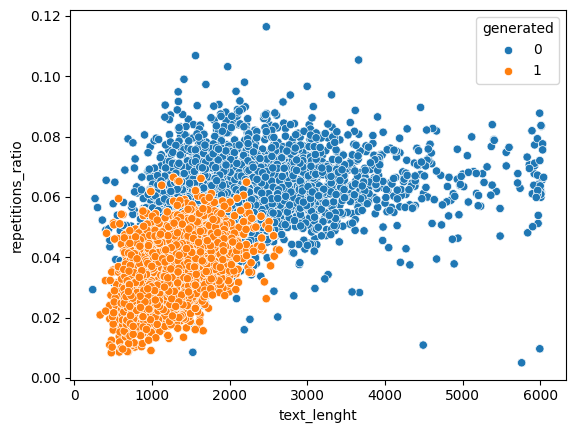

In [28]:
sns.scatterplot(data=df, x="text_lenght", y="repetitions_ratio", hue="generated")

In [33]:
df.groupby(['generated'])['repetitions_ratio'].median()

generated
0    0.061697
1    0.034673
Name: repetitions_ratio, dtype: float64

In [34]:
df.groupby(['generated'])['repetitions_ratio'].std()

generated
0    0.012117
1    0.009793
Name: repetitions_ratio, dtype: float64